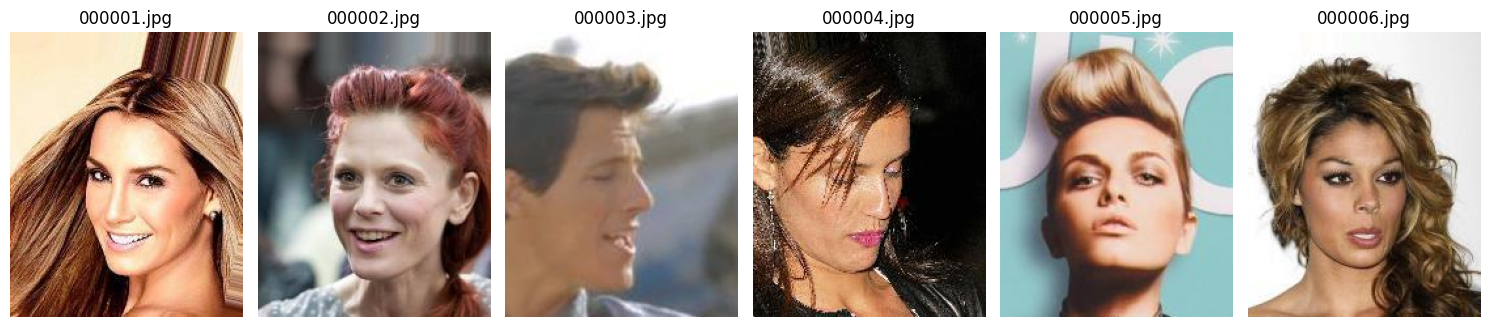

In [46]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

IMG_DIR = 'img_align_celeba'
ATTR_CSV = 'list_attr_celeba.csv'

df = pd.read_csv(ATTR_CSV)

n = 6
fig, axes = plt.subplots(1, n, figsize=(15, 5))
for ax, img_name in zip(axes, df['image_id'].head(n)):
    img_path = os.path.join(IMG_DIR, img_name)
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(img_name)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [47]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())

CUDA available: True
GPU count: 1


In [48]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image

IMG_DIR   = 'img_align_celeba'
ATTR_CSV  = 'list_attr_celeba.csv'
SPLIT_CSV = 'list_eval_partition.csv'

BATCH_SIZE      = 64
IMG_SIZE        = 128
WARMUP_EPOCHS   = 3
FINETUNE_EPOCHS = 7
LR_HEAD         = 1e-3
LR_FT           = 1e-4
WEIGHT_DECAY    = 1e-5
NUM_WORKERS     = 4

In [49]:
class CelebADataset(Dataset):
    def __init__(self, attr_csv, img_dir, split_csv, split, transform):
        df = pd.read_csv(attr_csv)
        df['Male'] = (df['Male'] == 1).astype(int)
        parts = pd.read_csv(split_csv)
        df = df.merge(parts, on='image_id')
        df = df[df['partition'] == {'train':0,'valid':1,'test':2}[split]]
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(os.path.join(self.img_dir, row['image_id'])).convert('RGB')
        if self.transform: img = self.transform(img)
        return img, int(row['Male'])

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

In [50]:
import random
import numpy as np

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False
    os.environ['PYTHONHASHSEED']       = str(seed)

set_seed(42)

In [51]:
train_ds = CelebADataset(ATTR_CSV, IMG_DIR, SPLIT_CSV, 'train', transform)
valid_ds = CelebADataset(ATTR_CSV, IMG_DIR, SPLIT_CSV, 'valid', transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.hub.load('pytorch/vision:v0.13.1', 'mobilenet_v2', pretrained=True)
in_feats = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_feats, 2)
model.to(device)

loss_fn = nn.CrossEntropyLoss()

def train_epoch(model, loader, opt):
    model.train()
    total = 0
    for imgs, labs in tqdm(loader, desc='Train', leave=False):
        imgs, labs = imgs.to(device), labs.to(device)
        opt.zero_grad()
        loss = loss_fn(model(imgs), labs)
        loss.backward()
        opt.step()
        total += loss.item()
    return total/len(loader)

def evaluate(model, loader):
    model.eval()
    preds, labs = [], []
    for imgs, labels in tqdm(loader, desc='Eval', leave=False):
        out = model(imgs.to(device)).argmax(1).cpu().tolist()
        preds += out
        labs  += labels.tolist()
    return (
        accuracy_score(labs, preds),
        precision_score(labs, preds),
        recall_score(labs, preds),
        f1_score(labs, preds),
    )

Using cache found in /home/chentang/.cache/torch/hub/pytorch_vision_v0.13.1


In [54]:
for p in model.features.parameters(): p.requires_grad = False
opt = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_HEAD)

print("=== Warmup Phase ===")
for epoch in range(1, WARMUP_EPOCHS+1):
    loss = train_epoch(model, train_loader, opt)
    acc, prec, rec, f1 = evaluate(model, valid_loader)
    print(f"Warmup {epoch}/{WARMUP_EPOCHS} • Loss {loss:.4f} • Acc {acc:.4f} • F1 {f1:.4f}")

=== Warmup Phase ===


Train:   0%|          | 0/2544 [00:00<?, ?it/s]

Eval:   0%|          | 0/311 [00:00<?, ?it/s]

Warmup 1/3 • Loss 0.2662 • Acc 0.9145 • F1 0.8983


Train:   0%|          | 0/2544 [00:00<?, ?it/s]

Eval:   0%|          | 0/311 [00:00<?, ?it/s]

Warmup 2/3 • Loss 0.2593 • Acc 0.9155 • F1 0.9028


Train:   0%|          | 0/2544 [00:00<?, ?it/s]

Eval:   0%|          | 0/311 [00:00<?, ?it/s]

Warmup 3/3 • Loss 0.2596 • Acc 0.9163 • F1 0.9012


In [55]:
for p in model.features.parameters(): p.requires_grad = True
opt = optim.Adam(model.parameters(), lr=LR_FT, weight_decay=WEIGHT_DECAY)

print("=== Fine-tune Phase ===")
best_acc, best_path = 0, None
for epoch in range(1, FINETUNE_EPOCHS+1):
    loss = train_epoch(model, train_loader, opt)
    acc, prec, rec, f1 = evaluate(model, valid_loader)
    print(f"Finetune {epoch}/{FINETUNE_EPOCHS} • Loss {loss:.4f} • Acc {acc:.4f} • F1 {f1:.4f}")
    if acc > best_acc:
        best_acc = acc
        best_path = 'best_model.pth'
        torch.save(model.state_dict(), best_path)

print(f"\nBest valid Acc: {best_acc:.4f} (saved to {best_path})")

=== Fine-tune Phase ===


Train:   0%|          | 0/2544 [00:00<?, ?it/s]

Eval:   0%|          | 0/311 [00:00<?, ?it/s]

Finetune 1/7 • Loss 0.0792 • Acc 0.9862 • F1 0.9838


Train:   0%|          | 0/2544 [00:00<?, ?it/s]

Eval:   0%|          | 0/311 [00:00<?, ?it/s]

Finetune 2/7 • Loss 0.0430 • Acc 0.9858 • F1 0.9833


Train:   0%|          | 0/2544 [00:00<?, ?it/s]

Eval:   0%|          | 0/311 [00:00<?, ?it/s]

Finetune 3/7 • Loss 0.0303 • Acc 0.9873 • F1 0.9851


Train:   0%|          | 0/2544 [00:00<?, ?it/s]

Eval:   0%|          | 0/311 [00:00<?, ?it/s]

Finetune 4/7 • Loss 0.0205 • Acc 0.9863 • F1 0.9838


Train:   0%|          | 0/2544 [00:00<?, ?it/s]

Eval:   0%|          | 0/311 [00:00<?, ?it/s]

Finetune 5/7 • Loss 0.0149 • Acc 0.9857 • F1 0.9832


Train:   0%|          | 0/2544 [00:00<?, ?it/s]

Eval:   0%|          | 0/311 [00:00<?, ?it/s]

Finetune 6/7 • Loss 0.0113 • Acc 0.9864 • F1 0.9839


Train:   0%|          | 0/2544 [00:00<?, ?it/s]

Eval:   0%|          | 0/311 [00:00<?, ?it/s]

Finetune 7/7 • Loss 0.0091 • Acc 0.9875 • F1 0.9853

Best valid Acc: 0.9875 (saved to best_model.pth)


In [56]:
test_ds    = CelebADataset(ATTR_CSV, IMG_DIR, SPLIT_CSV, 'test', transform)
test_loader= DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.to(device).eval()

test_acc, test_prec, test_rec, test_f1 = evaluate(model, test_loader)

print(f"=== Test Set Metrics ===")
print(f"Accuracy : {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall   : {test_rec:.4f}")
print(f"F1-score : {test_f1:.4f}")

Eval:   0%|          | 0/312 [00:00<?, ?it/s]

=== Test Set Metrics ===
Accuracy : 0.9811
Precision: 0.9819
Recall   : 0.9689
F1-score : 0.9753


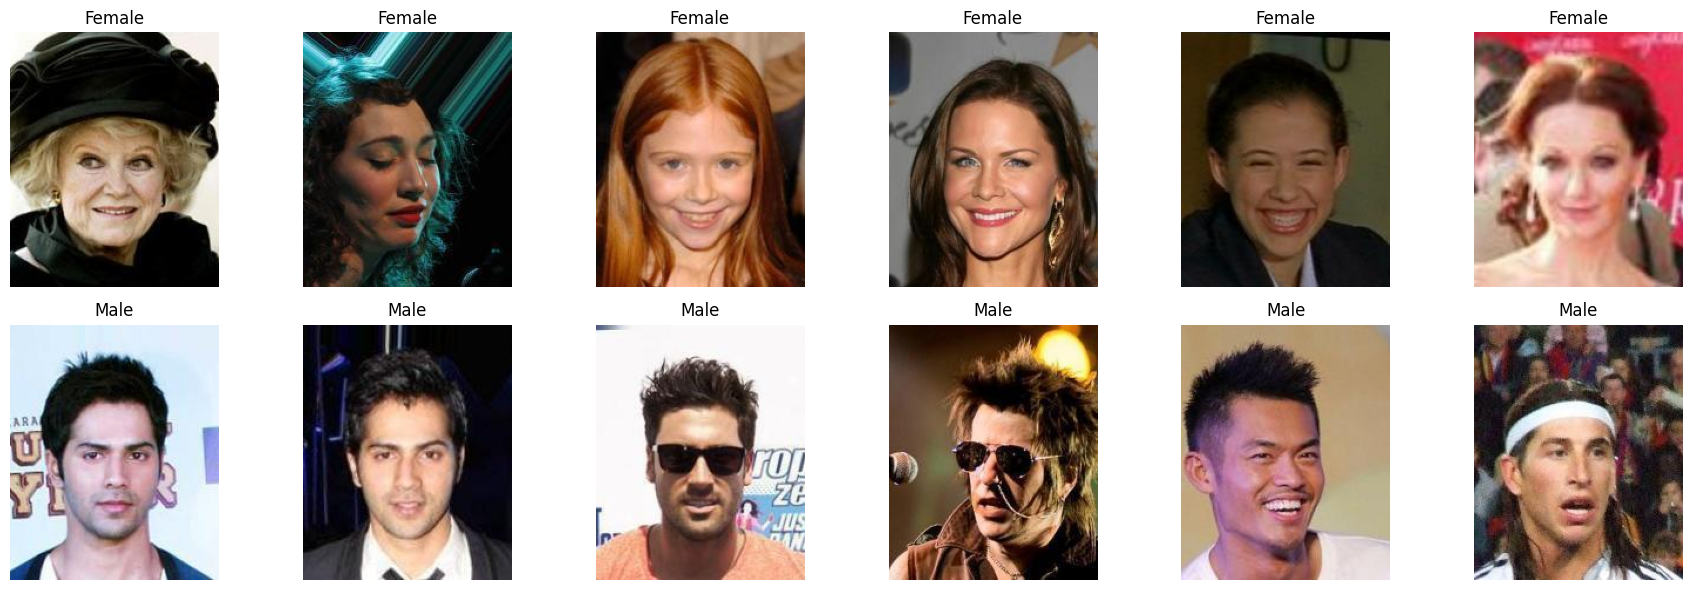

In [57]:
preds = []
model.eval()
for imgs, _ in test_loader:
    imgs = imgs.to(device)
    with torch.no_grad():
        out = model(imgs).argmax(dim=1).cpu().tolist()
    preds.extend(out)

image_ids = test_ds.df['image_id'].tolist()

pairs = list(zip(image_ids, preds))
female_imgs = [fn for fn, p in pairs if p == 0][:6]
male_imgs   = [fn for fn, p in pairs if p == 1][:6]

fig, axes = plt.subplots(2, 6, figsize=(18, 6))
for ax, img_name in zip(axes[0], female_imgs):
    img = mpimg.imread(os.path.join(IMG_DIR, img_name))
    ax.imshow(img)
    ax.set_title('Female')
    ax.axis('off')

for ax, img_name in zip(axes[1], male_imgs):
    img = mpimg.imread(os.path.join(IMG_DIR, img_name))
    ax.imshow(img)
    ax.set_title('Male')
    ax.axis('off')

plt.tight_layout()
plt.show()